**TRABALHO PRATICO 2** 

**Franci Rrapi (UFMG - 2021/1)**

**3) RRT ALGORITHM**

**IMPLEMENTATION and TESTS**

Below is the implementation of this algorithm and you can find also the image tests made (they are also saved and available in the same folder of the notebook)

In [1]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# pip install shapely
# conda install --channel conda-forge shapely
# pip install descartes

# https://pypi.org/project/Shapely/
# https://shapely.readthedocs.io/en/latest/manual.html
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import Polygon

from descartes.patch import PolygonPatch

In [3]:
def Rz(theta):
  
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

def Rx(theta):
 
    return np.array([[  1, 0            , 0           ],
                      [ 0, np.cos(theta),-np.sin(theta)],
                      [ 0, np.sin(theta), np.cos(theta)]])
  

def Ry(theta):
 
    return np.array([[  np.cos(theta), 0, np.sin(theta)],
                      [ 0            , 1, 0           ],
                      [-np.sin(theta), 0, np.cos(theta)]])


Creation of objects for our scene

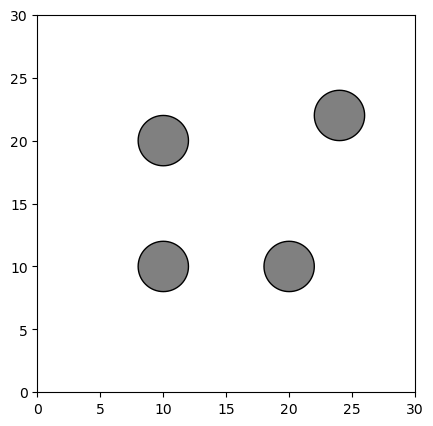

In [4]:
WORLDX, WORLDY = 30, 30 
r = 2
p1 = [10, 20, r]
p2 = [10, 10, r]
p3 = [20, 10, r]
p4 = [24, 22, r]

# Criando obstáculos
obs1 = Point(p1).buffer(r)
obs2 = Point(p2).buffer(r)
obs3 = Point(p3).buffer(r)
obs4 = Point(p4).buffer(r)

obs_set = [obs1, obs2, obs3, obs4]

# Método para plotar o mapa
def plot_map(obs_set):

    fig = plt.figure(figsize=(8,5), dpi=100)
    ax = fig.add_subplot(111, aspect='equal') 

    for obs in obs_set:
        ax.add_patch(PolygonPatch(obs, facecolor='gray'))
        
    ax.set_xlim(0, WORLDX)
    ax.set_ylim(0, WORLDY)
    
    plt.savefig("./obs.png")

    
plot_map(obs_set)

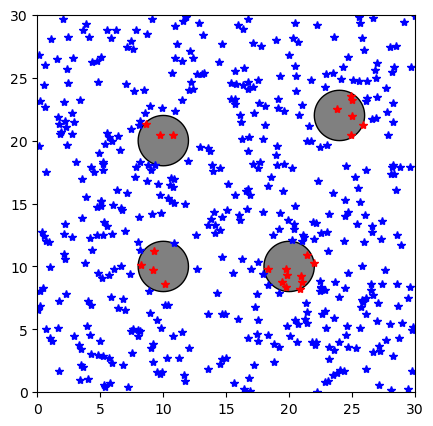

In [5]:
N = 500

# Gerando amostras aleatóras
samples = []
for n in range(N):
    x = np.random.uniform(0, WORLDX)
    y = np.random.uniform(0, WORLDY)
    samples.append(Point([x, y]))
    
    
# Verificando as que são inválidas    
invalid_samples = []
for s in samples:
    for o in obs_set:
        if s.intersects(o):
            invalid_samples.append(s)

            
# Salvando as amostras válidas em um vetor específico
valid_samples = list(filter(lambda samples: samples not in invalid_samples, samples))
    
plot_map(obs_set)
            
for v in valid_samples:
    plt.plot(*v.xy, 'b*')
    
for i in invalid_samples:
    plt.plot(*i.xy, 'r*')

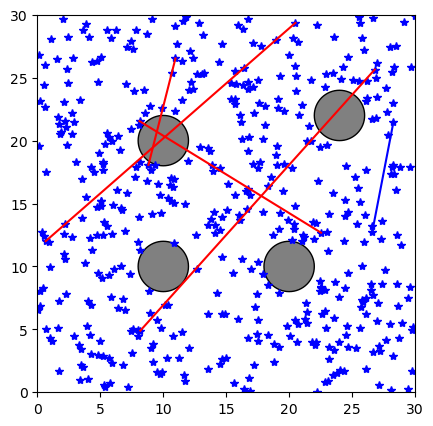

In [6]:
plot_map(obs_set)
            
for v in valid_samples:
    plt.plot(*v.xy, 'b*')
    
# Selecionado pares amostras aleatórias e verificando se o caminho é válido
for i in range(5):
    points = random.sample(valid_samples, 2)
    line = LineString(points)

    c = 'blue'
    for o in obs_set:
        if line.intersects(o):
            c = 'red'
    
    x, y = line.xy
    plt.gca().plot(x, y, color=c)

In [7]:
def plot_scene(obstacle_list, start, goal):
    ax = plt.gca()
    for o in obstacle_list:
        circle = plt.Circle((o[0], o[1]), o[2], color='k')
        ax.add_artist(circle)
    plt.axis([bounds[0]-0.5, bounds[1]+0.5, bounds[0]-0.5, bounds[1]+0.5])
    plt.plot(start[0], start[1], "xr", markersize=10)
    plt.plot(goal[0], goal[1], "xb", markersize=10)
    plt.legend(('start', 'goal'), loc='upper left')
    plt.gca().set_aspect('equal')

RRT class that implements the algorithm

In [8]:
class RRT:
 
    class Node:
        def __init__(self, p):
            self.p = np.array(p)
            self.parent = None

    def __init__(self, start, goal, obstacle_list, bounds, 
                 max_extend_length=3.0, path_resolution=0.8, 
                 goal_sample_rate=0.05, max_iter=100):
        self.start = self.Node(start)
        self.goal = self.Node(goal)
        self.bounds = bounds
        self.max_extend_length = max_extend_length
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []

    def plan(self):
        """Plans the path from start to goal while avoiding obstacles"""
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # modify here: 
            # 1) Create a random node (rnd_node) inside 
            # the bounded environment
            # 2) Find nearest node (nearest_node)
            # 3) Get new node (new_node) by connecting
            # rnd_node and nearest_node. Hint: steer
            # 4) If the path between new_node and the
            # nearest node is not in collision, add it to the node_list
            
            # Create a random node inside the bounded environment
            loop = True
            while loop:    
                rnd = self.get_random_node(self.obstacle_list)
                if rnd != None:
                    loop = False
            
            # Find nearest node
            nearest_node = self.get_nearest_node(self.node_list, rnd)
            # Get new node by connecting rnd_node and nearest_node
            new_node = self.steer(nearest_node, rnd, self.max_extend_length)
            # If path between new_node and nearest node is not in collision:
            if not self.collision(new_node, nearest_node, self.obstacle_list):
                self.node_list.append(new_node)
    
            # Don't need to modify beyond here
            # If the new_node is very close to the goal, connect it
            # directly to the goal and return the final path
            if self.dist_to_goal(self.node_list[-1].p) <= self.max_extend_length:
                final_node = self.steer(self.node_list[-1], self.goal, self.max_extend_length)
                if not self.collision(final_node, self.node_list[-1], self.obstacle_list):
                    return self.final_path(len(self.node_list) - 1)
        return None  # cannot find path
    

    def steer(self, from_node, to_node, max_extend_length=np.inf):
        """Connects from_node to a new_node in the direction of to_node
        with maximum distance max_extend_length
        """
        new_node = self.Node(to_node.p)
        d = from_node.p - to_node.p
        dist = np.linalg.norm(d)
        if dist > max_extend_length:
            # rescale the path to the maximum extend_length
            new_node.p  = from_node.p - d / dist * max_extend_length
        new_node.parent = from_node
        return new_node

    def dist_to_goal(self, p):
        """Distance from p to goal"""
        return np.linalg.norm(p - self.goal.p)

    def get_random_node(self, obstacle_list):
        """Sample random node inside bounds or sample goal point"""
        if np.random.rand() > self.goal_sample_rate:
            # Sample random point inside boundaries
            rnd = self.Node(np.random.rand(2)*(self.bounds[1]-self.bounds[0]) + self.bounds[0])
        else:  
            # Select goal point
            rnd = self.Node(self.goal.p)
        p = Point(rnd.p)
        for o in obstacle_list:
            x, y, r, = o[0], o[1], o[2]
            obs = Point([x, y]).buffer(r)
            if p.intersects(obs):
                return None
        return rnd
    
    @staticmethod
    def get_nearest_node(node_list, node):
        """Find the nearest node in node_list to node"""
        dlist = [np.sum(np.square((node.p - n.p))) for n in node_list]
        minind = dlist.index(min(dlist))
        return node_list[minind]
    
    @staticmethod
    def collision(node1, node2, obstacle_list):
        """Check whether the path connecting node1 and node2 
        is in collision with anyting from the obstacle_list
        """
        p1 = Point(node2.p)
        p2 = Point(node1.p)
        points = [p1, p2]
        line = LineString(points)

        for o in obstacle_list:
            obs = Point(o).buffer(o[2])
            if line.intersects(obs):
                return True
        return False

                    
#         for o in obstacle_list:
#             center_circle = o[0:2]
#             radius = o[2]
#             d12 = p2 - p1 # the directional vector from p1 to p2
#             # defines the line v(t) := p1 + d12*t going through p1=v(0) and p2=v(1)
#             d1c = center_circle - p1 # the directional vector from circle to p1
#             # t is where the line v(t) and the circle are closest
#             # Do not divide by zero if node1.p and node2.p are the same.
#             # In that case this will still check for collisions with circles
#             t = d12.dot(d1c) / (d12.dot(d12) + 1e-7)
#             t = max(0, min(t, 1)) # Our line segment is bounded 0<=t<=1
#             d = p1 + d12*t # The point where the line segment and circle are closest
#             is_collide = np.sum(np.square(center_circle-d)) < radius**2
#             if is_collide:
#                 return True # is in collision
#         return False # is not in collision
    
    def final_path(self, goal_ind):
        """Compute the final path from the goal node to the start node"""
        path = []
        for i in range(goal_ind):
            node = self.node_list[i]
            path.append(node.p)
        # modify here: Generate the final path from the goal node to the start node.
        # We will check that path[0] == goal and path[-1] == start
        path.append(self.goal.p)
#         if path[0] != self.start.p or path[-1] != self.goal.p:
#             return None
        return path

    def draw_graph(self):
        for node in self.node_list:
            if node.parent:
                plt.plot([node.p[0], node.parent.p[0]], [node.p[1], node.parent.p[1]], "-g")

Program started
Connected to remote API server
START: [3.77499199 8.04999733]
GOAL: [16.95000076 17.39999962]
[3.77499199 8.04999733]
[6.22151377 9.78623786]
[ 7.72967725 12.37958376]
[10.59106418 13.28095206]
[13.10897221 14.91194536]
[16.95000076 17.39999962]
6
ok
ok
ok
ok
ok
Program ended


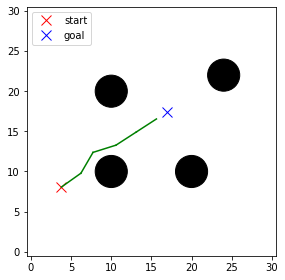

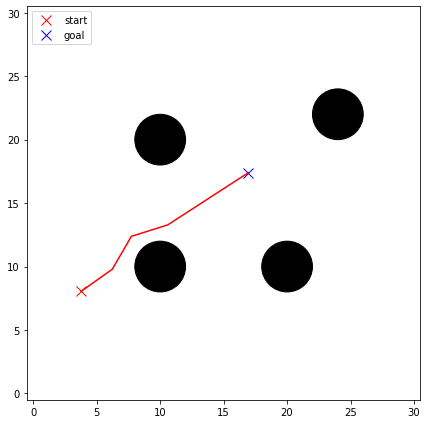

In [11]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    robotname = 'robotino'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait) 
    returnCode, refHandle = sim.simxGetObjectHandle(clientID, "ReferenceFrame0", sim.simx_opmode_oneshot_wait)
    returnCode, goalHandle = sim.simxGetObjectHandle(clientID, "Goal", sim.simx_opmode_oneshot_wait)
                 
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
    returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
    qstart = np.array([pos[0], pos[1], ori[2]])
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, goalHandle, refHandle, sim.simx_opmode_oneshot_wait)
    returnCode, ori = sim.simxGetObjectOrientation(clientID, goalHandle, refHandle, sim.simx_opmode_oneshot_wait)
    goal_angle = np.arctan2(pos[1]-qstart[1], pos[0] - qstart[0])
    qgoal = np.array([pos[0], pos[1], goal_angle])
    
    
    start = np.array([qstart[0], qstart[1]]) # Start location
    goal = np.array([qgoal[0], qgoal[1]]) # Goal location
    
    print("START: {}".format(start))
    print("GOAL: {}".format(goal))
    
    obstacles = [ # circles parametrized by [x, y, radius]
            np.asarray(p1),
            np.asarray(p2),
            np.asarray(p3),
            np.asarray(p4)
    ] 

    bounds = np.array([0, 30]) # Bounds in both x and y
    
    plt.figure()
    plot_scene(obstacles, start, goal)
    plt.tight_layout()
    
    np.random.seed(7)
    rrt = RRT(start=start,
              goal=goal,
              bounds=bounds,
              obstacle_list=obstacles, 
              max_extend_length=3.0, 
              path_resolution=0.5, 
              goal_sample_rate=0.5, 
              max_iter=100)
    path_rrt = rrt.plan()
    
    for elem in path_rrt:
        print(elem)
    print(len(path_rrt))
    
    
    rrt.draw_graph()
    plt.figure(figsize=(6,6))
    plot_scene(obstacles, start, goal)
    if path_rrt is None:
        print("No viable path found")
        sys.exit(0)
    else:
        plt.plot([x for (x, y) in path_rrt], [y for (x, y) in path_rrt], '-r')
    plt.tight_layout()

               
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
           
    
#     gain = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    gain = np.array([[0.3, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])    
   

    t = 0
    # Lembrar de habilitar o 'Real-time mode'
    startTime=time.time()
    lastTime = startTime
    
    limit = 200
    
    path = []
    for i in range(1, len(path_rrt)):
        if t >= limit:
            print("Tempo finito")
            break
        print("ok")
        elem = path_rrt[i]
        qgoal = np.array([elem[0], elem[1], 0])
        
        while t < limit:
            
            now = time.time()
            dt = now - lastTime 

            returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
            returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
            q = np.array([pos[0], pos[1], ori[2]])
            
            path.append(q[:2])
        
            error = qgoal - q
        
            # Margem aceitável de distância
            if (np.linalg.norm(error[:2]) < 0.5):
                break

            # Controller
            qdot = gain @ error

            # Cinemática Inversa
            # w1, w2, w3
            Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
            u = Minv @ qdot

            # Enviando velocidades
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming) 
            
            t = t + dt  
            lastTime = now
               
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

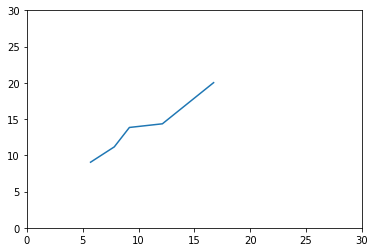

In [23]:
# print(path)
x_val = [x[0] for x in path_rrt]
y_val = [x[1] for x in path_rrt]

plt.plot(x_val,y_val)
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()